# Segmenting customers by RFM Score

The purpose of this notebook is to use K-Means Clustering to segment a customer base in 3 groups based on their RFM Score.


## RFM

The RFM Score (Recency, Frequency, Monetary Value) is a metric that analyzes the customer based on three data points:

- **Recency**: How recently the customer made a purchase
- **Frequency**: How often do they purchase
- **Monetary Value**: How much they spent

RFM analysis classifies customers with a numerical ranking of the three categories, with the ideal customer earning the highest on each category.


## The Data

The dataset contains about a year worth of transactions (dec-2010 to dec-2011) from an **online retail company** based on in the UK. More information can be found on [Kaggle](https://www.kaggle.com/vijayuv/onlineretail). 




In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# K-Means to cluster the users
from sklearn.cluster import KMeans

# Yellowbrick for Model visualization
from yellowbrick.cluster import KElbowVisualizer

In [52]:
# Define the functions
def order_clusters(cluster, target, df, ascending):
    new_cluster = 'new' + cluster
    
    temp = df.groupby(cluster)[target].mean().reset_index()
    temp = temp.sort_values(by=target, ascending=ascending).reset_index(drop=True)
    temp['index'] = temp.index
    
    cluster_df = pd.merge(df, temp[[cluster, 'index']], on=cluster)
    cluster_df = cluster_df.drop([cluster], axis=1)
    cluster_df = cluster_df.rename(columns={'index':cluster})
    
    return cluster_df

def rfm_cluster(df, cluster_variable, n_clusters, ascending):
    
    # Create and fit the k-means 
    model = KMeans(n_clusters=n_clusters)
    model.fit(df[[cluster_variable]])
    
    # predict the cluster and pass it to the dataframe
    df[cluster_variable + 'Cluster'] = model.predict(df[[cluster_variable]])
    
    # order the cluster numbers
    df = order_clusters(cluster_variable + 'Cluster', cluster_variable, df, ascending)
    
    return df

In [53]:
# Import the data
df = pd.read_csv('data/ecommerce.csv', encoding='cp1252', parse_dates=['InvoiceDate'])

# I'll only keep UK sales
df = df[df.Country == 'United Kingdom']

In [54]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    495478 non-null  object        
 1   StockCode    495478 non-null  object        
 2   Description  494024 non-null  object        
 3   Quantity     495478 non-null  int64         
 4   InvoiceDate  495478 non-null  datetime64[ns]
 5   UnitPrice    495478 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      495478 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


In [56]:
maxdate = df['InvoiceDate'].dt.date.max()
mindate = df['InvoiceDate'].dt.date.min()
customers = df['CustomerID'].nunique()
stock = df['StockCode'].nunique()
quantity = df['Quantity'].sum()

print(f'Transactions timeframe: {mindate} to {maxdate}.')
print(f'Unique customers: {customers}.')
print(f'Unique items sold: {stock}.')
print(f'Quantity sold in period {quantity}')

Transactions timeframe: 2010-12-01 to 2011-12-09.
Unique customers: 3950.
Unique items sold: 4065.
Quantity sold in period 4263829


In [57]:
# Create a users dataframe to segment
users = pd.DataFrame(df['CustomerID'].unique())
users.columns = ['CustomerID']

### Recency
For the purpose of this project, I'll consider the last day in the dataset as if it were the present day to calculate Recency

In [58]:
# Get the latest purchase date for each customer and pass it to a df
max_purchase = df.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']
max_purchase['MaxPurchaseDate'] = max_purchase['MaxPurchaseDate'].dt.date

# Calculate Recency
max_purchase['Recency'] = (
    max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days 

# Merge the dataframe with the users to get the Recency value for each customer
users = pd.merge(users, max_purchase[['CustomerID', 'Recency']], on='CustomerID')
users.head()

,CustomerID,Recency
0,17850.0,302
1,13047.0,31
2,13748.0,95
3,15100.0,330
4,15291.0,25


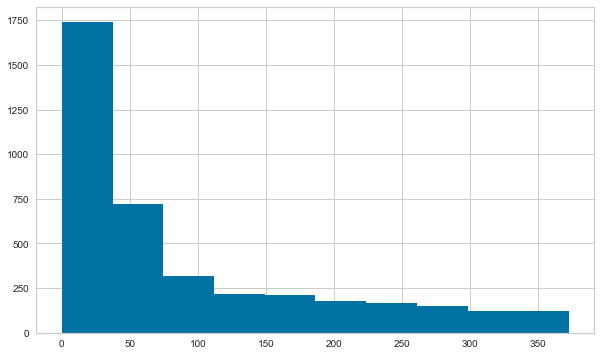

In [59]:
# plot a histogram of Recency
fig = plt.figure(figsize=(10, 6))
plt.hist(users['Recency']);

The distribution of Recency is very skewed which, in this case, is actually good. We see that the majority of clients have bought something between 0 and 50 days ago.

In [60]:
# Describe Recency
users['Recency'].describe()

count    3950.000000
mean       91.323038
std       100.236848
min         0.000000
25%        16.000000
50%        50.000000
75%       143.000000
max       373.000000
Name: Recency, dtype: float64

The number of optimal clusters seems to be 2, but I'll use 3 just for the sake of demonstration

### Frequency

In [61]:
# calculate the frequency score, that is how 
# frequently the customer buy from the store
frequency_score = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
frequency_score.columns = ['CustomerID', 'Frequency']

In [62]:
users = pd.merge(users, frequency_score, on='CustomerID')
users.head()

,CustomerID,Recency,Frequency
0,17850.0,302,312
1,13047.0,31,196
2,13748.0,95,28
3,15100.0,330,6
4,15291.0,25,109


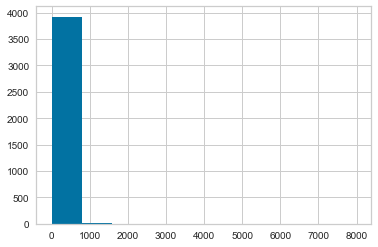

In [63]:
# Plot the distribution 
plt.hist(users['Frequency']);

Unlike the recency cluster, a higher median (50%) frequency indicates a better customer.

### Monetary Value (Revenue)

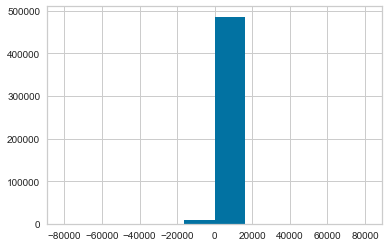

In [64]:
plt.hist(df['Quantity']);

There are negative values for `Quantity` these could be returned goods, but the Kaggle page doesn't say anything about it, so I'll exclude those from the analysis just for demonstration.

In [65]:
df.drop(df[df['Quantity']<0].index, axis=0, inplace=True)

In [66]:
# Calculate revenue for each individual customer
df['Revenue'] = df['UnitPrice']*df['Quantity']

In [67]:
# Calculate revenue for each individual customer
df['Revenue'] = df['UnitPrice']*df['Quantity']
revenue = df.groupby('CustomerID')['Revenue'].mean().reset_index()

# Merge the revenue with users dataframe
users = pd.merge(users, revenue, on='CustomerID')

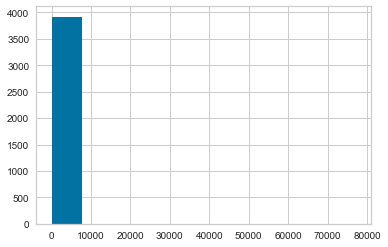

In [68]:
# Plot the data
plt.hist(users['Revenue']);

## Creating the clusters

Now, we'll apply K-means clustering to assign the scores. 

To find out how many clusters we need, we'll apply the Elbow Method on 'Recency' to work as a standard for the entire RFM analysis

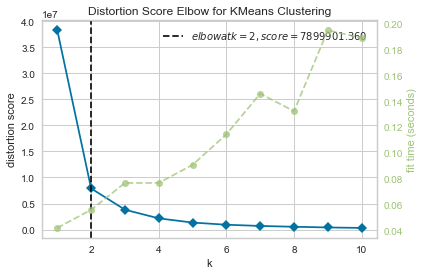

In [69]:
model = KMeans()

recency_score = users[['Recency']]

visualizer = KElbowVisualizer(model, k=(1, 11))

visualizer.fit(recency_score)
visualizer.show();

The optimum amount of clusters is 2, but I'll use 3 for this project

### Recency Cluster

In [111]:
# Create the Recency cluster, smaller recency is 
# better, so we set ascending to False
users = rfm_cluster(users, 'Recency', 3, False)

# Check the df with the clusters
users.head()

,CustomerID,Recency,Frequency,Revenue,RevenueCluster,OverallScore,Segment,FrequencyCluster,RecencyCluster
0,17850.0,302,312,18.152222,0,1,Medium,1,0
1,15100.0,330,6,292.000000,0,0,Medium,0,0
2,18074.0,373,13,37.661538,0,0,Medium,0,0
3,16250.0,261,24,16.226667,0,0,Medium,0,0
4,13747.0,373,1,79.600000,0,0,Medium,0,0


In [112]:
# Now every customer has been assigned to a cluster based on their Recency
# and the clusters are ordered from lowest to highest
users.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,543.0,292.209945,44.894589,225.0,254.0,283.0,324.0,373.0
1,723.0,154.347165,37.941635,93.0,120.0,155.0,186.0,222.0
2,2655.0,30.995104,25.174245,0.0,9.0,24.0,50.0,92.0


### Monetary Value (Revenue) Cluster

In [103]:
rfm_cluster(users, 'Revenue', 4, True)

,CustomerID,Recency,Frequency,Revenue,OverallScore,Segment,FrequencyCluster,RecencyCluster,RevenueCluster
0,17850.0,302,312,18.152222,-1,Low,1,0,0
1,15100.0,330,6,292.000000,-2,Low,0,0,0
2,18074.0,373,13,37.661538,-2,Low,0,0,0
3,16250.0,261,24,16.226667,-2,Low,0,0,0
4,13747.0,373,1,79.600000,-2,Low,0,0,0
...,...,...,...,...,...,...,...,...,...
3916,13130.0,94,2,32.000000,-1,Low,0,1,0
3917,13210.0,93,22,16.067273,-1,Low,0,1,0
3918,12346.0,325,2,77183.600000,0,Medium,0,0,3
3919,16446.0,0,4,56157.500000,1,Medium,0,2,2


In [113]:
users.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3918.0,34.364325,133.636653,0.0,11.145,17.278286,24.371273,4453.43
1,1.0,77183.600000,NaN,77183.6,77183.600,77183.600000,77183.600000,77183.60
2,1.0,56157.500000,NaN,56157.5,56157.500,56157.500000,56157.500000,56157.50
3,1.0,13305.500000,NaN,13305.5,13305.500,13305.500000,13305.500000,13305.50


### Frequency cluster

In [114]:
# Create the Frequency Clusters
users = rfm_cluster(users,'Frequency', 3, True)

# describe the clusters
users.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3652.0,58.766156,58.412558,1.0,16.0,37.0,84.00,272.0
1,266.0,486.578947,311.017362,273.0,316.0,393.0,518.25,2782.0
2,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.50,7983.0


## Overall RFM Score

For this RFM model, all the features will have the same weight, but this can easily be adjusted in the formula below:

In [116]:
# Calculate OverallScore
users['OverallScore'] = users['FrequencyCluster'] + users['RevenueCluster'] - users['RecencyCluster'] 

# Show the mean of the features for each OverallScore value
users.groupby('OverallScore')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
-2,32.999582,72.791719,32.176291
-1,116.854657,158.744115,35.546965
0,288.503636,58.800000,143.847047
1,313.500000,157.000000,38600.876111
2,182.000000,5.000000,13305.500000


We can arbitrarily assign labels for the different Overall Score clusters for the sake of simplicity

| Value   | Label  |
|---------|--------|
| (-2,-1) | Low    |
| (0,1)   | Medium |
| (2,4)   | High   |

In [117]:
# Create the Segment variable based on the OverallScore
x = users['OverallScore']
conditions = [x<0, x<2]
choices = ['Low', 'Medium']

users['Segment'] = np.select(conditions, choices, default='High')

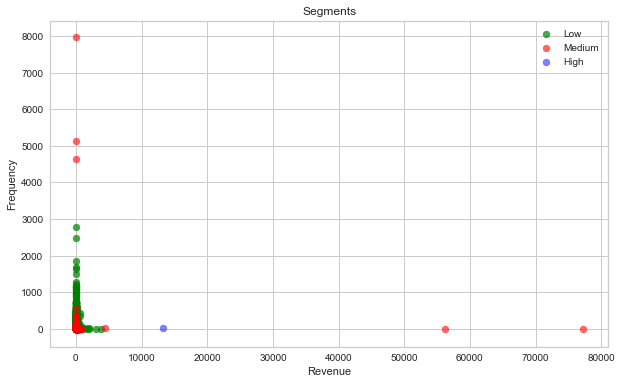

In [118]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
    
plt.scatter(x=users.query("Segment == 'Low'")['Revenue'],
            y= users.query("Segment == 'Low'")['Frequency'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=users.query("Segment == 'Medium'")['Revenue'],
            y=users.query("Segment == 'Medium'")['Frequency'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=users.query("Segment == 'High'")['Revenue'],
            y=users.query("Segment == 'High'")['Frequency'],
            c='blue', alpha=0.5, label='High')

plt.legend();

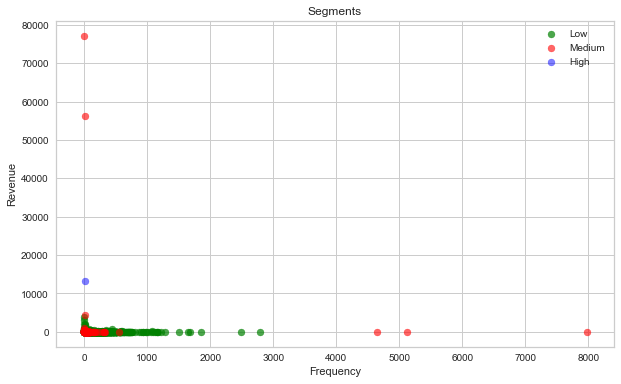

In [119]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Frequency')
plt.ylabel('Revenue')
    
plt.scatter(x=users.query("Segment == 'Low'")['Frequency'],
            y= users.query("Segment == 'Low'")['Revenue'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=users.query("Segment == 'Medium'")['Frequency'],
            y=users.query("Segment == 'Medium'")['Revenue'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=users.query("Segment == 'High'")['Frequency'],
            y=users.query("Segment == 'High'")['Revenue'],
            c='blue', alpha=0.5, label='High')

plt.legend();

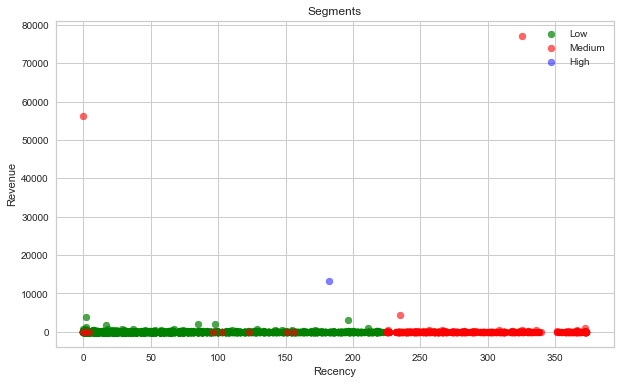

In [120]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Recency')
plt.ylabel('Revenue')

plt.scatter(x=users.query("Segment == 'Low'")['Recency'],
            y= users.query("Segment == 'Low'")['Revenue'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=users.query("Segment == 'Medium'")['Recency'],
            y=users.query("Segment == 'Medium'")['Revenue'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=users.query("Segment == 'High'")['Recency'],
            y=users.query("Segment == 'High'")['Revenue'],
            c='blue', alpha=0.5, label='High')

plt.legend();


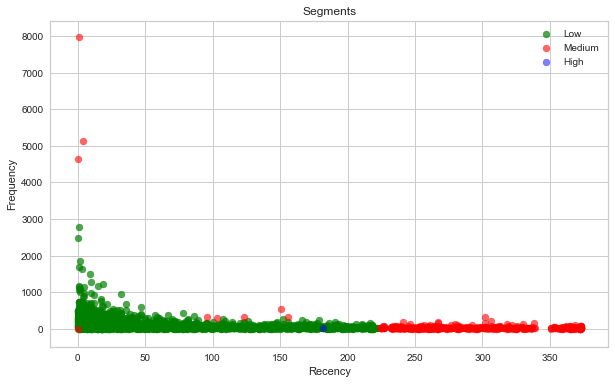

In [121]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Recency')
plt.ylabel('Frequency')
    
plt.scatter(x=users.query("Segment == 'Low'")['Recency'],
            y= users.query("Segment == 'Low'")['Frequency'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=users.query("Segment == 'Medium'")['Recency'],
            y=users.query("Segment == 'Medium'")['Frequency'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=users.query("Segment == 'High'")['Recency'],
            y=users.query("Segment == 'High'")['Frequency'],
            c='blue', alpha=0.5, label='High')

plt.legend();

We can see the segments behave differently so we can apply adequate strategies to the each group.

In [122]:
users.head()

,CustomerID,Recency,Frequency,Revenue,RevenueCluster,OverallScore,Segment,RecencyCluster,FrequencyCluster
0,17850.0,302,312,18.152222,0,1,Medium,0,1
1,14688.0,7,359,17.219786,0,-1,Low,2,1
2,15311.0,0,2491,25.543464,0,-1,Low,2,1
3,14527.0,2,1011,8.753930,0,-1,Low,2,1
4,17511.0,2,1076,94.561142,0,-1,Low,2,1
